<a href="https://colab.research.google.com/github/sggyuan/GNN/blob/main/%E8%AE%BA%E6%96%87%E5%87%BA%E7%A8%BF%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GAE
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = torch.load('/content/drive/MyDrive/my_graph_data-bal.pt')

<ipython-input-4-e9945f3ad513>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/content/drive/MyDrive/my_graph_data-bal.pt')


In [ ]:
data = train_test_split_edges(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
data

Data(x=[16283, 13], y=[100000], val_pos_edge_index=[2, 5000], val_pos_edge_attr=[5000, 8], test_pos_edge_index=[2, 10000], test_pos_edge_attr=[10000, 8], train_pos_edge_index=[2, 99038], train_pos_edge_attr=[99038, 8], train_neg_adj_mask=[16283, 16283], val_neg_edge_index=[2, 5000], test_neg_edge_index=[2, 10000])

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        # First GCN layer
        x1 = F.leaky_relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Second GCN layer with residual connection
        x2 = F.leaky_relu(self.bn2(self.conv2(x1, edge_index))) + x1
        x2 = self.dropout(x2)

        # Final GCN layer
        x3 = self.conv3(x2, edge_index)

        return x3


In [ ]:
out_channels = 2
num_features = data.num_features
epochs = 100

model1 = GAE(GCNEncoder(num_features, out_channels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=10, factor=0.5)


In [ ]:
def train1():
    model1.train()
    optimizer.zero_grad()
    z = model1.encode(x, train_pos_edge_index)
    loss = model1.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
from __future__ import division

import torch
import torch.nn.functional as F
from torch_scatter import scatter_add


def true_positive(pred, target, num_classes):
    r"""Computes the number of true positive predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target == i)).sum())

    return torch.tensor(out)



def true_negative(pred, target, num_classes):
    r"""Computes the number of true negative predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target != i)).sum())

    return torch.tensor(out)



def false_positive(pred, target, num_classes):
    r"""Computes the number of false positive predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target != i)).sum())

    return torch.tensor(out)


def false_negative(pred, target, num_classes):
    r"""Computes the number of false negative predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target == i)).sum())

    return torch.tensor(out)

def precision(pred, target, num_classes):
    r"""Computes the precision
    :math:`\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fp = false_positive(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fp)
    out[torch.isnan(out)] = 0

    return out




def recall(pred, target, num_classes):
    r"""Computes the recall
    :math:`\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fn = false_negative(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fn)
    out[torch.isnan(out)] = 0

    return out



def f1_score(pred, target, num_classes):
    r"""Computes the :math:`F_1` score
    :math:`2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}
    {\mathrm{precision}+\mathrm{recall}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    prec = precision(pred, target, num_classes)
    rec = recall(pred, target, num_classes)

    score = 2 * (prec * rec) / (prec + rec)
    score[torch.isnan(score)] = 0

    return score

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
def test1(pos_edge_index, neg_edge_index):
    model1.eval()
    with torch.no_grad():
        z = model1.encode(x, train_pos_edge_index)
        pos_out = model1.decode(z, pos_edge_index)
        neg_out = model1.decode(z, neg_edge_index)

        pred_scores = torch.cat([pos_out, neg_out], dim=0)

        y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)
        pred_scores = pred_scores.cpu()
        y_true = y_true.cpu()
        y_pred = (pred_scores > 0.5).long()

        auc = roc_auc_score(y_true.numpy(), pred_scores.numpy())
        ap = average_precision_score(y_true.numpy(), pred_scores.numpy())


        num_classes = 2
        rec = recall(y_pred, y_true, num_classes)[1]
        f1 = f1_score(y_pred, y_true, num_classes)[1]

    return auc, ap, rec.item(), f1.item()


for epoch in range(1, epochs + 1):
    loss = train1()
    auc, ap, rec, f1 = test1(data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}, '
          f'Recall: {rec:.4f}, F1: {f1:.4f}')

Epoch: 001, AUC: 0.7462, AP: 0.6641, Recall: 0.9999, F1: 0.6667
Epoch: 002, AUC: 0.8689, AP: 0.8106, Recall: 0.9997, F1: 0.6667
Epoch: 003, AUC: 0.8950, AP: 0.8684, Recall: 0.9994, F1: 0.6672
Epoch: 004, AUC: 0.8960, AP: 0.8918, Recall: 0.9957, F1: 0.6705
Epoch: 005, AUC: 0.8587, AP: 0.8587, Recall: 0.9654, F1: 0.6868
Epoch: 006, AUC: 0.8557, AP: 0.8812, Recall: 0.9321, F1: 0.6910
Epoch: 007, AUC: 0.8512, AP: 0.8887, Recall: 0.9068, F1: 0.6891
Epoch: 008, AUC: 0.8494, AP: 0.8892, Recall: 0.9026, F1: 0.6918
Epoch: 009, AUC: 0.8441, AP: 0.8854, Recall: 0.8923, F1: 0.6960
Epoch: 010, AUC: 0.8332, AP: 0.8726, Recall: 0.8788, F1: 0.7069
Epoch: 011, AUC: 0.8176, AP: 0.8488, Recall: 0.8623, F1: 0.7144
Epoch: 012, AUC: 0.7941, AP: 0.7981, Recall: 0.8443, F1: 0.7166
Epoch: 013, AUC: 0.7859, AP: 0.7794, Recall: 0.8393, F1: 0.7113
Epoch: 014, AUC: 0.7718, AP: 0.7535, Recall: 0.8290, F1: 0.6988
Epoch: 015, AUC: 0.7000, AP: 0.6711, Recall: 0.7680, F1: 0.6499
Epoch: 016, AUC: 0.5118, AP: 0.5439, Rec

# VGAE

In [ ]:
from torch_geometric.nn import VGAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class VariationalGCNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # First GCN layer
        x1 = F.leaky_relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Second GCN layer with residual connection
        x2 = F.leaky_relu(self.bn2(self.conv2(x1, edge_index))) + x1
        x2 = self.dropout(x2)

        # Final GCN layers for mean and log-standard deviation
        mu = self.conv_mu(x2, edge_index)
        logstd = self.conv_logstd(x2, edge_index)

        return mu, logstd

    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

In [ ]:
out_channels = 2
num_features = data.num_features
epochs = 300


model2 = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=10, factor=0.5)

In [ ]:
def train2():
    model2.train()
    optimizer.zero_grad()
    z = model2.encode(x, train_pos_edge_index)
    loss = model2.recon_loss(z, train_pos_edge_index)

    loss = loss + (1 / data.num_nodes) * model2.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)

def test2(pos_edge_index, neg_edge_index):
    model2.eval()
    with torch.no_grad():
        z = model2.encode(x, train_pos_edge_index)
        pos_out = model2.decode(z, pos_edge_index)
        neg_out = model2.decode(z, neg_edge_index)

        pred_scores = torch.cat([pos_out, neg_out], dim=0)
        y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)

        pred_scores = pred_scores.cpu()
        y_true = y_true.cpu()

        y_pred = (pred_scores > 0.5).long()

        auc = roc_auc_score(y_true.numpy(), pred_scores.numpy())
        ap = average_precision_score(y_true.numpy(), pred_scores.numpy())

        num_classes = 2
        rec = recall(y_pred, y_true, num_classes)[1]
        f1 = f1_score(y_pred, y_true, num_classes)[1]

    return auc, ap, rec.item(), f1.item()

for epoch in range(1, epochs + 1):
    loss = train2()
    auc, ap, rec, f1 = test2(data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}, '
          f'Recall: {rec:.4f}, F1: {f1:.4f}')

Epoch: 001, Loss: 25.6526, AUC: 0.5890, AP: 0.5490, Recall: 1.0000, F1: 0.6667
Epoch: 002, Loss: 5.1516, AUC: 0.7103, AP: 0.6441, Recall: 0.9996, F1: 0.6668
Epoch: 003, Loss: 2.4716, AUC: 0.8254, AP: 0.7956, Recall: 0.9831, F1: 0.6624
Epoch: 004, Loss: 1.7628, AUC: 0.8597, AP: 0.8674, Recall: 0.9562, F1: 0.6558
Epoch: 005, Loss: 1.5286, AUC: 0.8707, AP: 0.8953, Recall: 0.9546, F1: 0.6538
Epoch: 006, Loss: 1.3369, AUC: 0.8762, AP: 0.9053, Recall: 0.9723, F1: 0.6588
Epoch: 007, Loss: 1.3697, AUC: 0.8856, AP: 0.9136, Recall: 0.9936, F1: 0.6663
Epoch: 008, Loss: 1.3362, AUC: 0.8901, AP: 0.9184, Recall: 0.9910, F1: 0.6670
Epoch: 009, Loss: 1.3393, AUC: 0.8833, AP: 0.9173, Recall: 0.9645, F1: 0.6670
Epoch: 010, Loss: 1.2605, AUC: 0.8807, AP: 0.9174, Recall: 0.9446, F1: 0.6697
Epoch: 011, Loss: 1.2313, AUC: 0.8803, AP: 0.9181, Recall: 0.9393, F1: 0.6739
Epoch: 012, Loss: 1.1742, AUC: 0.8791, AP: 0.9182, Recall: 0.9334, F1: 0.6741
Epoch: 013, Loss: 1.1467, AUC: 0.8801, AP: 0.9187, Recall: 0.93

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def test_and_collect_scores(model, data, test_pos_edge_index, test_neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        pos_pred = model.decode(z, test_pos_edge_index).sigmoid()
        neg_pred = model.decode(z, test_neg_edge_index).sigmoid()

        pred_scores = torch.cat([pos_pred, neg_pred]).cpu().numpy()
        true_labels = np.concatenate([np.ones(pos_pred.size(0)), np.zeros(neg_pred.size(0))])

    return true_labels, pred_scores


all_true_labels1 = []
all_pred_scores1 = []

for epoch in range(1, epochs + 1):
    loss = train1()
    auc, ap, rec, f1 = test1(data.test_pos_edge_index, data.test_neg_edge_index)

    true_labels, pred_scores = test_and_collect_scores(model1, data, data.test_pos_edge_index, data.test_neg_edge_index)

    all_true_labels1.extend(true_labels)
    all_pred_scores1.extend(pred_scores)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}, '
          f'Recall: {rec:.4f}, F1: {f1:.4f}')

Epoch: 001, Loss: 1.4498, AUC: 0.8501, AP: 0.9013, Recall: 0.8712, F1: 0.7130
Epoch: 002, Loss: 1.4050, AUC: 0.8507, AP: 0.9017, Recall: 0.8715, F1: 0.7143
Epoch: 003, Loss: 1.2807, AUC: 0.8516, AP: 0.9025, Recall: 0.8726, F1: 0.7129
Epoch: 004, Loss: 1.2977, AUC: 0.8516, AP: 0.9025, Recall: 0.8733, F1: 0.7118
Epoch: 005, Loss: 1.4391, AUC: 0.8518, AP: 0.9026, Recall: 0.8736, F1: 0.7122
Epoch: 006, Loss: 1.3058, AUC: 0.8514, AP: 0.9023, Recall: 0.8731, F1: 0.7119
Epoch: 007, Loss: 1.5019, AUC: 0.8511, AP: 0.9020, Recall: 0.8724, F1: 0.7141
Epoch: 008, Loss: 1.2872, AUC: 0.8513, AP: 0.9022, Recall: 0.8724, F1: 0.7144
Epoch: 009, Loss: 1.2849, AUC: 0.8512, AP: 0.9021, Recall: 0.8721, F1: 0.7159
Epoch: 010, Loss: 1.2732, AUC: 0.8524, AP: 0.9031, Recall: 0.8735, F1: 0.7163
Epoch: 011, Loss: 1.3026, AUC: 0.8521, AP: 0.9028, Recall: 0.8735, F1: 0.7156
Epoch: 012, Loss: 1.2797, AUC: 0.8518, AP: 0.9026, Recall: 0.8728, F1: 0.7164
Epoch: 013, Loss: 1.3642, AUC: 0.8514, AP: 0.9024, Recall: 0.872

In [ ]:
all_true_labels2 = []
all_pred_scores2 = []

for epoch in range(1, epochs + 1):
    loss = train2()
    auc, ap, rec, f1 = test2(data.test_pos_edge_index, data.test_neg_edge_index)

    true_labels, pred_scores = test_and_collect_scores(model2, data, data.test_pos_edge_index, data.test_neg_edge_index)

    all_true_labels2.extend(true_labels)
    all_pred_scores2.extend(pred_scores)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}, '
          f'Recall: {rec:.4f}, F1: {f1:.4f}')

Epoch: 001, Loss: 0.9579, AUC: 0.8782, AP: 0.9190, Recall: 0.8978, F1: 0.7419
Epoch: 002, Loss: 0.9570, AUC: 0.8799, AP: 0.9199, Recall: 0.9001, F1: 0.7428
Epoch: 003, Loss: 0.9593, AUC: 0.8808, AP: 0.9202, Recall: 0.9014, F1: 0.7434
Epoch: 004, Loss: 0.9621, AUC: 0.8806, AP: 0.9202, Recall: 0.9017, F1: 0.7431
Epoch: 005, Loss: 0.9641, AUC: 0.8773, AP: 0.9181, Recall: 0.8977, F1: 0.7413
Epoch: 006, Loss: 0.9587, AUC: 0.8756, AP: 0.9172, Recall: 0.8951, F1: 0.7401
Epoch: 007, Loss: 0.9582, AUC: 0.8743, AP: 0.9163, Recall: 0.8927, F1: 0.7391
Epoch: 008, Loss: 0.9557, AUC: 0.8729, AP: 0.9152, Recall: 0.8923, F1: 0.7400
Epoch: 009, Loss: 0.9642, AUC: 0.8750, AP: 0.9170, Recall: 0.8947, F1: 0.7409
Epoch: 010, Loss: 0.9577, AUC: 0.8786, AP: 0.9198, Recall: 0.8986, F1: 0.7415
Epoch: 011, Loss: 0.9554, AUC: 0.8812, AP: 0.9217, Recall: 0.9014, F1: 0.7420
Epoch: 012, Loss: 0.9559, AUC: 0.8823, AP: 0.9223, Recall: 0.9032, F1: 0.7425
Epoch: 013, Loss: 0.9573, AUC: 0.8821, AP: 0.9222, Recall: 0.902

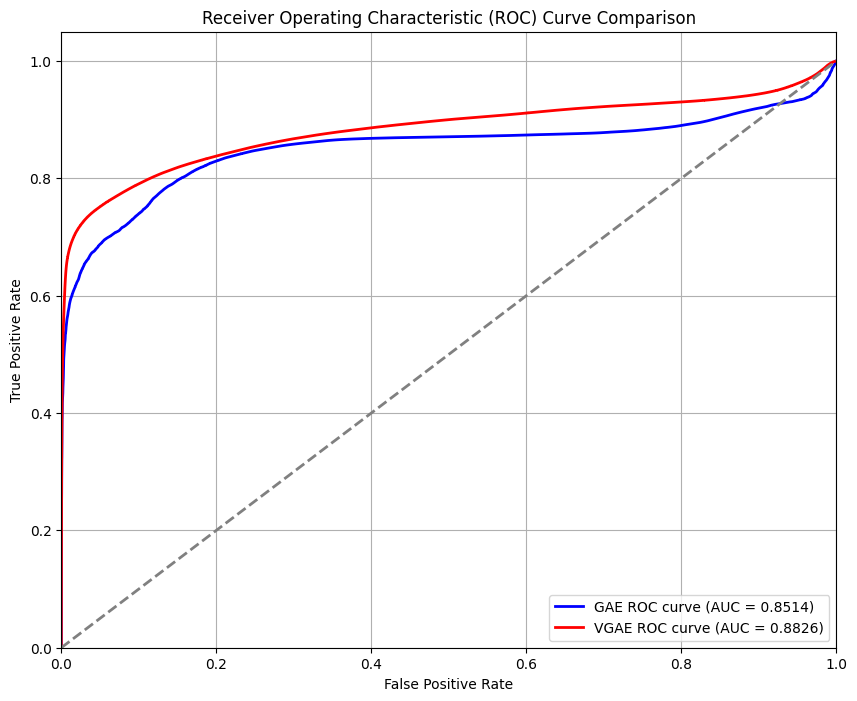

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr_gae, tpr_gae, _ = roc_curve(all_true_labels1, all_pred_scores1)
roc_auc_gae = auc(fpr_gae, tpr_gae)


fpr_vgae, tpr_vgae, _ = roc_curve(all_true_labels2, all_pred_scores2)
roc_auc_vgae = auc(fpr_vgae, tpr_vgae)


plt.figure(figsize=(10, 8))


plt.plot(fpr_gae, tpr_gae, color='blue', lw=2,
         label=f'GAE ROC curve (AUC = {roc_auc_gae:.4f})')


plt.plot(fpr_vgae, tpr_vgae, color='red', lw=2,
         label=f'VGAE ROC curve (AUC = {roc_auc_vgae:.4f})')


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)


plt.savefig('gae_vgae_roc_comparison.png', dpi=300, bbox_inches='tight')


plt.show()

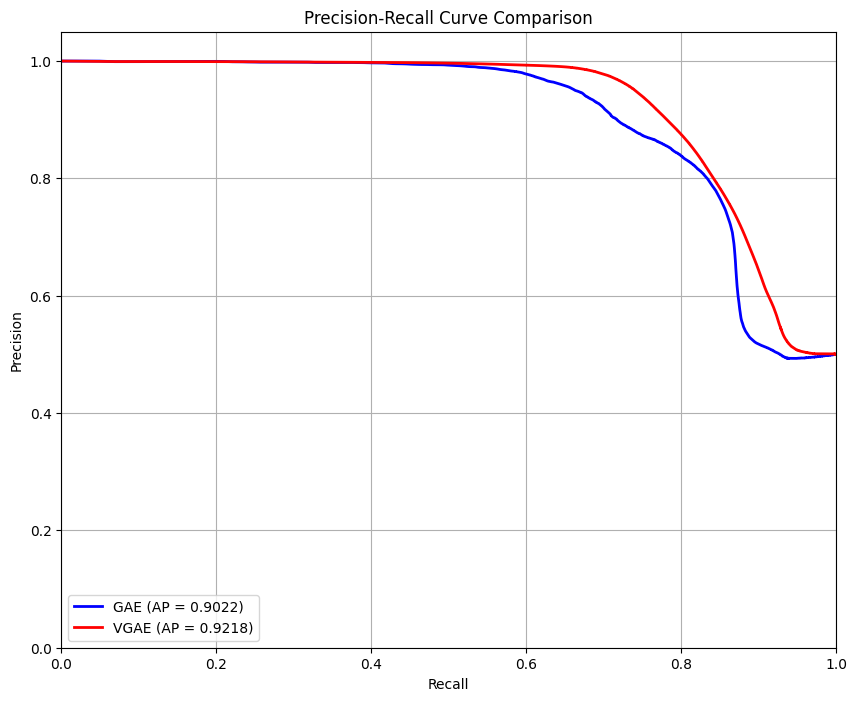

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision_gae, recall_gae, _ = precision_recall_curve(all_true_labels1, all_pred_scores1)
ap_gae = average_precision_score(all_true_labels1, all_pred_scores1)

precision_vgae, recall_vgae, _ = precision_recall_curve(all_true_labels2, all_pred_scores2)
ap_vgae = average_precision_score(all_true_labels2, all_pred_scores2)


plt.figure(figsize=(10, 8))


plt.plot(recall_gae, precision_gae, color='blue', lw=2,
         label=f'GAE (AP = {ap_gae:.4f})')

plt.plot(recall_vgae, precision_vgae, color='red', lw=2,
         label=f'VGAE (AP = {ap_vgae:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="lower left")
plt.grid(True)

plt.savefig('gae_vgae_pr_comparison.png', dpi=300, bbox_inches='tight')

plt.show()